<a href="https://colab.research.google.com/github/JMML2021/Entrega-projecte-final/blob/main/utilitzar_loggistic_regression_per_mirar_els_coeficients_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
 
#@title importació
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix

In [2]:
#@title Configuració warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
#@title Activo Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Obrir fitxer creat amb Calculo Vueling 2022 con codigos Rev D.ipynb
#path='/content/drive/MyDrive/2022.06.03 2022_delay + cierre puertas CORTO.xlsx'
Hoja = 'FLT_2022'
path = ('/content/drive/MyDrive/Ficheros de Vueling/2022-09-20 14:39:04.960091 FLT_2022.xlsx')
path = ('/content/drive/MyDrive/Ficheros de Vueling/2022-10-10 07:25:00.012463 FLT_2022.xlsx')
df = pd.read_excel(path) #, sheet_name=Hoja)




In [77]:
# Para crear una "logistic regresion":
# 10 minuts és el temps que s'accepta com arribar a l'hora

df['Tard1'] = np.where(df['Puntualidad1'] <10, 0, 1)
df['Tard2'] = np.where(df['Puntualidad2'] <10, 0, 1)
df['Tard3'] = np.where(df['Puntualidad3'] <10, 0, 1)

accuracy=[]

In [78]:
#@title crec el DataFrame df1
df1=df[['Puntualidad1', 'Puntualidad2', 'Puntualidad3', 
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3', 'Tard1', 'Tard2', 'Tard3']]

In [79]:
#@title Elimino els outliers. df2
df2=df1.copy()

dfEliminarOutliers= ((df2['E_Despegue']> -30) & 
                     (df2['E_Despegue']< 30) & 
                     (df2['Puntualidad1']< 30) & 
                     (df2['Puntualidad1']>-30) &
                     (df2['Puntualidad2']< 30) & 
                     (df2['Puntualidad2']>-30)&
                     (df2['E_Despegue2']< 30) & 
                     (df2['E_Despegue2']>-30)&
                     (df2['Puntualidad3']< 30) & 
                     (df2['Puntualidad3']>-30)&
                     (df2['E_Despegue3']< 30) & 
                     (df2['E_Despegue3']>-30))

df2 = df2[dfEliminarOutliers]

In [80]:
#@title Quantitat de outliers que hi ha
print(df1.shape)
print(df2.shape)
percentatje= round((df2.shape[0]-df1.shape[0])/df1.shape[0]*100/3,2)
print('quantitat de files afectades per outliers per salt= ', percentatje)

(12358, 12)
(10708, 12)
quantitat de files afectades per outliers per salt=  -4.45


In [81]:
#@title Creo Subrutina de metricas:

#Importo scikit-learn metrics module para el calculo
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
metricasEjercicio2=[]
######################################################################
 
def MetricasModelo(metodo, Y_real, Y_calculado, scores):
  print('Metodo: ', metodo)
  
  #Precisión del modelo: ¿con qué frecuencia es correcto el clasificador?
  #accuracy = metrics.accuracy_score(Y_real, Y_calculado)
  #print("Accuracy:", accuracy)

  rmse = np.sqrt(mean_squared_error(Y_real, Y_calculado,))
  print("RMSE: %f" % (rmse))
  

  R_squared = r2_score(Y_real, Y_calculado,)

  print("R-Squared: ", np.round(R_squared, 2))
 
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
  accuracy = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

  # Guardo metricas
  metricasEjercicio2.append([metodo, rmse, R_squared, accuracy])  


  cnf_matrix_SVM = metrics.confusion_matrix(Y_real, Y_calculado)

  print('\n\nMatriz de Confusión')
  print(cnf_matrix_SVM)


  # Creamos la Matriz de Confusion:

  class_names=[0,1] # name  of classes
  
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap

  sns.heatmap(pd.DataFrame(cnf_matrix_SVM), annot=True, cmap="gist_ncar" ,fmt='g')
  ax.xaxis.set_label_position("top")
 

  plt.tight_layout()
  plt.title('Matriu de confusió', y=1.1)
  plt.ylabel('Valor Actual')
  plt.xlabel('Valor predit')
  plt.Text(1.5,257.44,'Predicció')


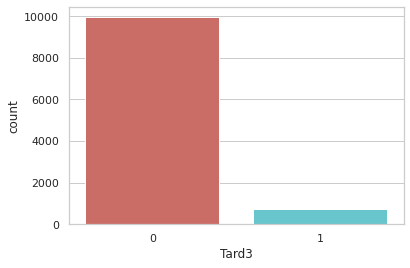

In [82]:
#@title Identificació del Desbalanceig
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=df2, palette='hls')
plt.show()

In [83]:
#@title Dades standarizatdes:

#@title Estandarditzar les característiques eliminant la mitjana i escalant a la variància de la unitat.

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler


mapper = DataFrameMapper([(df2.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df2.copy(), 4)
df2_StdScaler= pd.DataFrame(scaled_features, index=df2.index, columns=df2.columns)

df2_StdScaler.head()

datos_x= df2_StdScaler.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df2.loc[:,['Tard3']]

X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

logit_model=sm.Logit( y_train, X_train)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.640394
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: -1.542    
Dependent Variable: Tard3            AIC:              10983.2350
Date:               2022-10-13 08:05 BIC:              11025.5683
No. Observations:   8566             Log-Likelihood:   -5485.6   
Df Model:           5                LL-Null:          -2158.1   
Df Residuals:       8560             LLR p-value:      1.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
    Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
-----------------------------------------------------------------
x1 -0.0017 1712852.5986 -0.0000 1.0000 -3357129.4057 3357129.4024
x2 -0.0040          nan     nan    nan           nan          nan
x3 -0.0060 1178154.9933 -0.0000 1.00

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [84]:
#@title Creació del model utilitzant matrius com a scikitlearn
# ================================================= =============================
# A la matriu de predictors cal afegir una columna de 1s per a l'intercept del model

import statsmodels.api as sm

# Divisió de les dades en train i test
# ==============================================================================
datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df2.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
logit_model=sm.Logit( y_train, X_train)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.194613
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.228      
Dependent Variable: Tard3            AIC:              3346.1032  
Date:               2022-10-13 08:05 BIC:              3388.4365  
No. Observations:   8566             Log-Likelihood:   -1667.1    
Df Model:           5                LL-Null:          -2158.1    
Df Residuals:       8560             LLR p-value:      4.4908e-210
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
---------------------------------------------------------------------
        Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
---------------------------------------------------------------------
x1      0.0870         nan        nan       nan        nan        nan
x2      0.0369      0.0022    17.0495    0.0000     0.0326     0.0411
x3      0.0305         nan        nan       nan        nan        nan
x4 

Accuracy: 1.00 (+/- 0.00)
Metodo:  Regr.Log. des-Balancejada
RMSE: 0.000000
R-Squared:  1.0
Accuracy: 1.00 (+/- 0.00)


Matriz de Confusión
[[2998    0]
 [   0  215]]


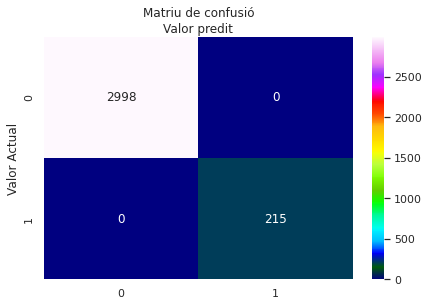

In [85]:
#@title Importo train_test_split function per dividir les dades en Test i Train
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#@title Crec la columna X e Y: 

datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3','E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values

datos_y = df2.loc[:,['Tard3']].values

#Dividims el dataset en training set y test set
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.3,random_state=109) # 70% training and 30% test


# instanciem el model (fem servir els paràmetres predeterminats)
logreg = LogisticRegression()

# fit el model
logreg.fit(X_train,y_train)

#
y_pred_RLogis=logreg.predict(X_test)

scores_RL = cross_val_score(logreg, X_train, y_train, cv=5)
 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RL.mean(), scores_RL.std() * 2))


MetricasModelo( 'Regr.Log. des-Balancejada', y_test, y_pred_RLogis, scores_RL)

In [86]:
#@title creem df2_sobremostrejat

from sklearn.utils import resample


# Classes majoritàries i minoritàries separades
df_majority = df2[df2.Tard3==0]
df_minority = df2[df2.Tard3==1]
 
# Upsample minority class
df_minority_sobremostrejat = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combina la classe majoritària amb la classe minoritària sobremostrejat
df2_sobremostrejat = pd.concat([df_majority, df_minority_sobremostrejat])

#Mostra els nous recomptes de classes
# 
df2_sobremostrejat.Tard3.value_counts()

0    9950
1    8000
Name: Tard3, dtype: int64

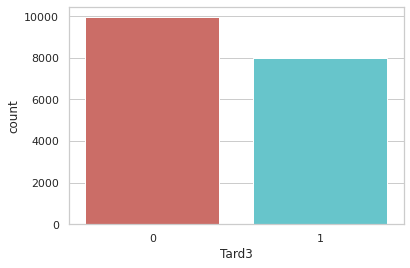

In [87]:
#@title df3= sobremostrejat
df3= df2_sobremostrejat
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=df3, palette='hls')
plt.show()

         Current function value: 0.146195
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.787    
Dependent Variable: Tard3            AIC:              4210.7180
Date:               2022-10-13 08:05 BIC:              4256.1512
No. Observations:   14360            Log-Likelihood:   -2099.4  
Df Model:           5                LL-Null:          -9865.6  
Df Residuals:       14354            LLR p-value:      0.0000   
Converged:          0.0000           Scale:            1.0000   
No. Iterations:     35.0000                                     
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
------------------------------------------------------------------
x1        0.0661        nan       nan      nan       nan       nan
x2        0.0273        nan       nan      nan       nan       nan
x3        0.0230        nan       nan  

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


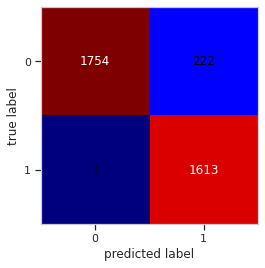

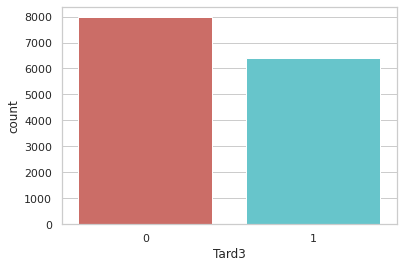

In [88]:
#@title 05.-Logistic regresion reSAMPLE tot
 
import statsmodels.api as sm

# Divisió de les dades en train i test
# ==============================================================================
datos_x= df3.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df3.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
logit_model=sm.Logit( y_train, X_train)
result=logit_model.fit()
print(result.summary2())


y_pred = result.predict(X_test)
prediction = list(map(round, y_pred))
prediction

#print(Counter(y_over))


print('classification_report')
print(classification_report(y_test, prediction))
print('confusion_matrix')

cf_matrix=plot_confusion_matrix(confusion_matrix(y_test, prediction), cmap='jet')

precision=round(accuracy_score(y_test, prediction),2)
accuracy.append(['8_Variables_Balanceado_TODO', precision])

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, prediction)))
print('Precision: {:.2f}'.format(precision_score(y_test, prediction)))
print('Recall: {:.2f}'.format(recall_score(y_test, prediction)))
print('f1_score: {:.2f}'.format(f1_score(y_test, prediction)))


fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=y_train, palette='hls')
plt.show()

x1    0.066129
x2    0.027339
x3    0.022951
x4   -0.049130
x5    0.368434
x6    0.043182
x7    0.076474
x8    0.376047
dtype: float64


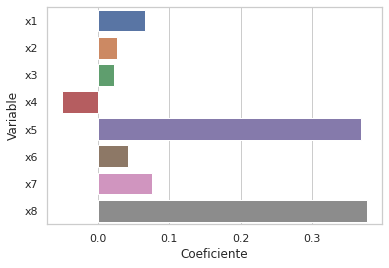

In [89]:
#@title Identificar parametres importants.
print(result.params)
parametros = pd.DataFrame(result.params)

parametros.columns=['Coeficiente']
parametros = parametros.rename_axis('Variable').reset_index()
parametros
sns.barplot(y='Variable', x="Coeficiente", data=parametros)

Optimization terminated successfully.
         Current function value: 0.134800
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.804    
Dependent Variable: Tard3            AIC:              3875.4456
Date:               2022-10-13 08:05 BIC:              3890.5900
No. Observations:   14360            Log-Likelihood:   -1935.7  
Df Model:           1                LL-Null:          -9865.6  
Df Residuals:       14358            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
E_Despegue3         4.3323   0.0880 49.2224 0.0000 4.1598 4.5048
E_Duracion_Vuelo3   3.6735   0.0774 47.4818 0.0000 3.5219 3.8251

classificati

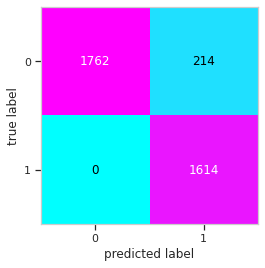

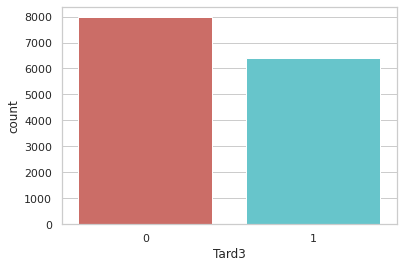

In [90]:
#@title 07.- Model balancejat "totes les dades", std, però només 2 variables importants:

exog_names = ['E_Despegue3','E_Duracion_Vuelo3']

mapper = DataFrameMapper([(exog_names, StandardScaler())])
scaled_features = mapper.fit_transform(df3.copy(), 4)
datos_x= pd.DataFrame(scaled_features, index=df3.index, columns=exog_names)
 
datos_y = df3.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
logit_model=sm.Logit( y_train, X_train)
result=logit_model.fit()
print(result.summary2())

y_pred = result.predict(X_test)
prediction = list(map(round, y_pred))
prediction

print('classification_report')
print(classification_report(y_test, prediction))
print('confusion_matrix')

cf_matrix=plot_confusion_matrix(confusion_matrix(y_test, prediction), cmap='cool')

precision=round(accuracy_score(y_test, prediction),2)
accuracy.append(['2_Variables_Balanceado_TODO_antes', precision])

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, prediction)))
print('Precision: {:.2f}'.format(precision_score(y_test, prediction)))
print('Recall: {:.2f}'.format(recall_score(y_test, prediction)))
print('f1_score: {:.2f}'.format(f1_score(y_test, prediction)))


fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=y_train, palette='hls')
plt.show()

https://vitalflux.com/handling-class-imbalance-sklearn-resample-python/


https://www.kaggle.com/code/eikedehling/exploring-class-imbalance-resampling-and-weights/notebook

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1978
           1       1.00      1.00      1.00       164

    accuracy                           1.00      2142
   macro avg       1.00      1.00      1.00      2142
weighted avg       1.00      1.00      1.00      2142



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58e1487110>)

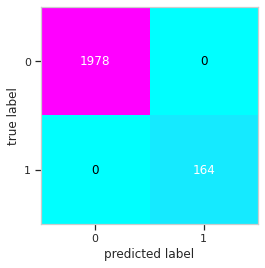

In [91]:

#@title Desbalancejat, LR
# ==============================================================================
datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df2.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

lr = LogisticRegression()

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), cmap='cool')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1978
           1       1.00      1.00      1.00       164

    accuracy                           1.00      2142
   macro avg       1.00      1.00      1.00      2142
weighted avg       1.00      1.00      1.00      2142



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58e1373ed0>)

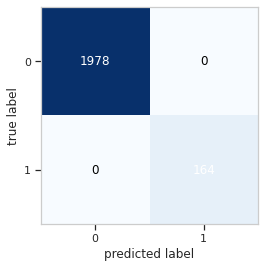

In [92]:
#@title Scaling..
datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
y = df2.loc[:,['Tard3']]

scaler = RobustScaler()
X = scaler.fit_transform(datos_x)

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

lr = LogisticRegression()

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))



Counter({'Tard3': 1})


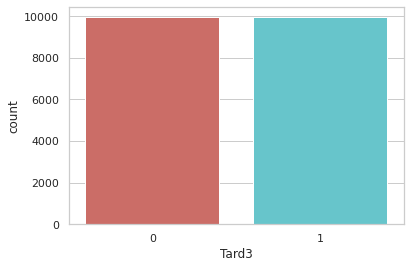

In [93]:
#@title Metodo de balanceig por "minority"
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))
y_over

#df3= df2_sobremostrejat
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=y_over, palette='hls')
plt.show()

In [94]:
#@title 06 Balancejan despres el X_train i el y_train

exog_names = ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]

mapper = DataFrameMapper([(exog_names, StandardScaler())])
scaled_features = mapper.fit_transform(df2.copy(), 4)
datos_x= pd.DataFrame(scaled_features, index=df2.index, columns=exog_names)

#datos_x= df2.loc[:, exog_names].values 

datos_y = df2.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

logit_model=sm.Logit( y_over, X_over)
result=logit_model.fit()
print(result.summary2())
print(result.summary())

         Current function value: 0.386345
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.443     
Dependent Variable: Tard3            AIC:              12331.7587
Date:               2022-10-13 08:05 BIC:              12377.8198
No. Observations:   15944            Log-Likelihood:   -6159.9   
Df Model:           5                LL-Null:          -11052.   
Df Residuals:       15938            LLR p-value:      0.0000    
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
Puntualidad1        -0.0072      nan     nan    nan    nan    nan
Puntualidad2        -0.0010      nan     nan    nan    nan    nan
E_Despegue          -0.0138      nan

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1978
           1       1.00      1.00      1.00       164

    accuracy                           1.00      2142
   macro avg       1.00      1.00      1.00      2142
weighted avg       1.00      1.00      1.00      2142



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58e14291d0>)

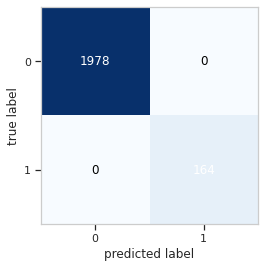

In [95]:


sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

prediction = list(map(round, y_pred))
prediction
print(classification_report(y_test, prediction))
plot_confusion_matrix(confusion_matrix(y_test, prediction))

https://michael-fuchs-python.netlify.app/2019/10/31/introduction-to-logistic-regression/

In [96]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, prediction)))
print('Precision: {:.2f}'.format(precision_score(y_test, prediction)))
print('Recall: {:.2f}'.format(recall_score(y_test, prediction)))
print('f1_score: {:.2f}'.format(f1_score(y_test, prediction)))

Accuracy: 1.00
Error rate: 0.00
Precision: 1.00
Recall: 1.00
f1_score: 1.00


**Accuracy** is the fraction of predictions our model got right.

**Error rate** is the fraction of predictions our model got wrong.

The **precision** is intuitively the ability of the classifier to not label a sample as positive if it is negative.

**The recall** is intuitively the ability of the classifier to find all the positive samples.

The **F1 score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

Puntualidad1        -0.007250
Puntualidad2        -0.001047
E_Despegue          -0.013813
E_Despegue2         -0.019594
E_Despegue3          1.124564
E_Duracion_Vuelo     0.002665
E_Duracion_Vuelo2    0.018632
E_Duracion_Vuelo3    0.948724
dtype: float64


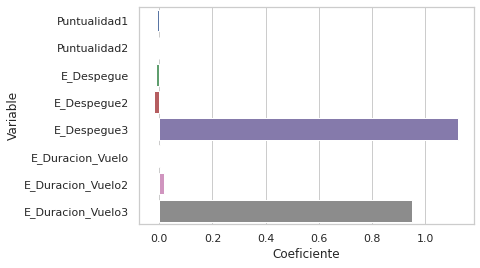

In [97]:
#@title Identificar parametres importants.
print(result.params)
parametros = pd.DataFrame(result.params)

parametros.columns=['Coeficiente']
parametros = parametros.rename_axis('Variable').reset_index()
parametros
sns.barplot(y='Variable', x="Coeficiente", data=parametros)

         Current function value: 0.194613
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                 8566
Model:                          Logit   Df Residuals:                     8560
Method:                           MLE   Df Model:                            5
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                  0.2275
Time:                        08:05:25   Log-Likelihood:                -1667.1
converged:                      False   LL-Null:                       -2158.1
Covariance Type:            nonrobust   LLR p-value:                4.491e-210
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Puntualidad1          0.0870        nan        nan        nan         nan         nan
Puntualidad2          0.0369      0.002     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


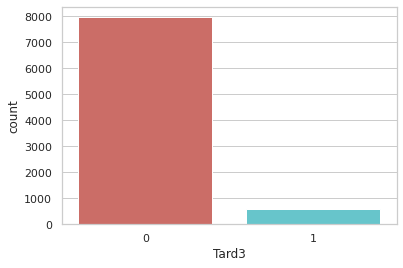

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1978
           1       1.00      1.00      1.00       164

    accuracy                           1.00      2142
   macro avg       1.00      1.00      1.00      2142
weighted avg       1.00      1.00      1.00      2142

Accuracy: 1.00
Error rate: 0.00
Precision: 1.00
Recall: 1.00
f1_score: 1.00


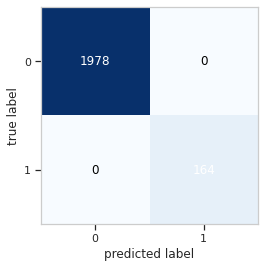

In [98]:
#@title 01.- Logistic Regression with the statsmodel library. Umbanaced


df2=pd.DataFrame(df2)
datos_x= df2.loc[:, ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 

 
datos_y = df2.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


model = sm.Logit(y_train, X_train)

model.exog_names[:] = ['Puntualidad1', 'Puntualidad2',  
        'E_Despegue','E_Despegue2','E_Despegue3',
        'E_Duracion_Vuelo','E_Duracion_Vuelo2','E_Duracion_Vuelo3',]
 
endog_name = model.endog_names


model_fit = model.fit()

print(model_fit.summary())

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=y_train, palette='hls')
plt.show()


# Predict..
y_pred = lr.predict(X_test)

prediction = list(map(round, y_pred))
prediction
print(classification_report(y_test, prediction))
plot_confusion_matrix(confusion_matrix(y_test, prediction))

precision=round(accuracy_score(y_test, prediction),2)
accuracy.append(['8_Variables_Unbalance', precision])

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, prediction)))
print('Precision: {:.2f}'.format(precision_score(y_test, prediction)))
print('Recall: {:.2f}'.format(recall_score(y_test, prediction)))
print('f1_score: {:.2f}'.format(f1_score(y_test, prediction)))

Puntualidad1         0.086985
Puntualidad2         0.036853
E_Despegue           0.030480
E_Despegue2         -0.062765
E_Despegue3          0.253739
E_Duracion_Vuelo     0.056519
E_Duracion_Vuelo2    0.099612
E_Duracion_Vuelo3    0.292412
dtype: float64


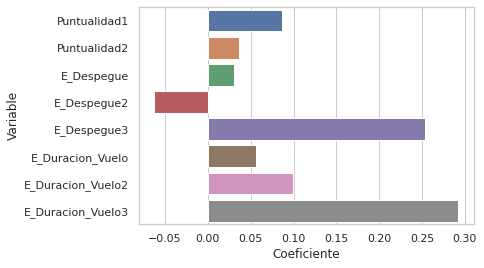

In [99]:
print(model_fit.params)
parametros = pd.DataFrame(model_fit.params)

parametros.columns=['Coeficiente']
parametros = parametros.rename_axis('Variable').reset_index()
parametros
sns.barplot(y='Variable', x="Coeficiente", data=parametros)

         Current function value: 0.154371
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                15944
Model:                          Logit   Df Residuals:                    15940
Method:                           MLE   Df Model:                            3
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                  0.7773
Time:                        08:05:26   Log-Likelihood:                -2461.3
converged:                      False   LL-Null:                       -11052.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0506        nan        nan        nan         nan         nan
x2            -0.0083        nan        nan        nan         na

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


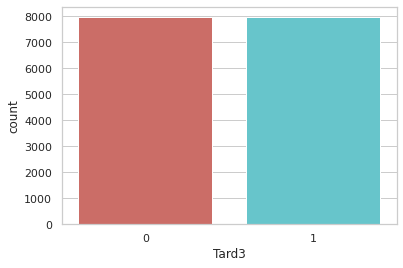

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1978
           1       0.39      1.00      0.56       164

    accuracy                           0.88      2142
   macro avg       0.70      0.94      0.75      2142
weighted avg       0.95      0.88      0.90      2142

Accuracy: 0.88
Error rate: 0.12
Precision: 0.39
Recall: 1.00
f1_score: 0.56


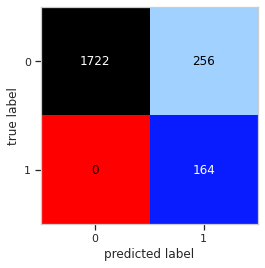

In [100]:
#@title 02 Logistic Regression with the statsmodel library. Balanced

datos_x= df2.loc[:, [ 'Puntualidad2', 'E_Despegue2','E_Despegue3', 'E_Duracion_Vuelo2','E_Duracion_Vuelo3',]].values 
datos_y = df2.loc[:,['Tard3']]

X_train, X_test, y_train, y_test = train_test_split(datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True )

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

model = sm.Logit(y_over, X_over)


model_fit = model.fit()

print(model_fit.summary())


y_pred = model_fit.predict(X_test)
prediction = list(map(round, y_pred))
prediction

print(Counter(y_over))

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=y_over, palette='hls')
plt.show()

print(classification_report(y_test, prediction))
plot_confusion_matrix(confusion_matrix(y_test, prediction), cmap='flag')

precision=round(accuracy_score(y_test, prediction),2)
accuracy.append(['6Variables_balanceadoTrain_escalado', precision])

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, prediction)))
print('Precision: {:.2f}'.format(precision_score(y_test, prediction)))
print('Recall: {:.2f}'.format(recall_score(y_test, prediction)))
print('f1_score: {:.2f}'.format(f1_score(y_test, prediction)))


x1    0.050588
x2   -0.008276
x3    0.320846
x4    0.058872
x5    0.353534
dtype: float64


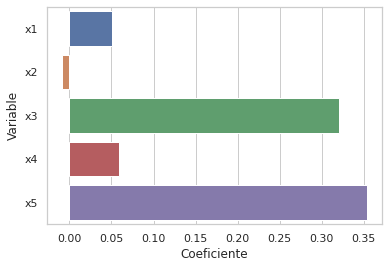

In [101]:
#@title Identificar parametres importants.
print(model_fit.params)
parametros = pd.DataFrame(model_fit.params)

parametros.columns=['Coeficiente']
parametros = parametros.rename_axis('Variable').reset_index()
parametros
sns.barplot(y='Variable', x="Coeficiente", data=parametros)

Optimization terminated successfully.
         Current function value: 0.154494
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                15944
Model:                          Logit   Df Residuals:                    15940
Method:                           MLE   Df Model:                            3
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                  0.7771
Time:                        08:05:26   Log-Likelihood:                -2463.3
converged:                       True   LL-Null:                       -11052.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
E_Despegue2           0.0425      0.004      9.712      0.000       0.034       0.051
E_Despeg

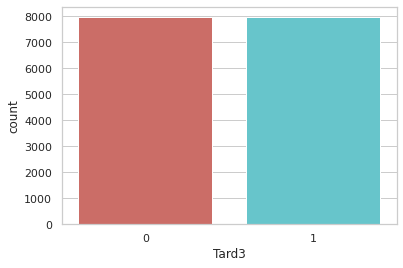

classification_report
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1978
           1       0.39      1.00      0.56       164

    accuracy                           0.88      2142
   macro avg       0.70      0.94      0.75      2142
weighted avg       0.95      0.88      0.90      2142

confusion_matrix
Accuracy: 0.88
Error rate: 0.12
Precision: 0.39
Recall: 1.00
f1_score: 0.56


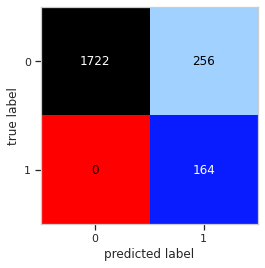

In [102]:
#@title 03 RL, balancejat el Train

exog_names = ['E_Despegue2','E_Despegue3', 'E_Duracion_Vuelo2','E_Duracion_Vuelo3',]

datos_x= df2.loc[:, exog_names].values
datos_y = df2.loc[:,['Tard3']]
X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True)

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

model = sm.Logit(y_over, X_over)
model.exog_names[:] = exog_names 
endog_name = model.endog_names

model_fit = model.fit()

print(model_fit.summary())

y_pred = model_fit.predict(X_test)
prediction = list(map(round, y_pred))
prediction

print(Counter(y_over))

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=y_over, palette='hls')
plt.show()

print('classification_report')
print(classification_report(y_test, prediction))
print('confusion_matrix')
plot_confusion_matrix(confusion_matrix(y_test, prediction), cmap='flag')


print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, prediction)))
print('Precision: {:.2f}'.format(precision_score(y_test, prediction)))
print('Recall: {:.2f}'.format(recall_score(y_test, prediction)))
print('f1_score: {:.2f}'.format(f1_score(y_test, prediction)))


E_Despegue2          0.042466
E_Despegue3          0.322572
E_Duracion_Vuelo2    0.110079
E_Duracion_Vuelo3    0.354232
dtype: float64


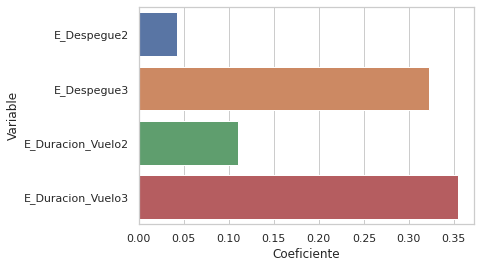

In [103]:
#@title 03 Identificar parametres importants.
print(model_fit.params)
parametros = pd.DataFrame(model_fit.params)

parametros.columns=['Coeficiente']
parametros = parametros.rename_axis('Variable').reset_index()
parametros
sns.barplot(y='Variable', x="Coeficiente", data=parametros)

Optimization terminated successfully.
         Current function value: 0.385708
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Tard3   No. Observations:                16920
Model:                          Logit   Df Residuals:                    16918
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                  0.4435
Time:                        08:05:27   Log-Likelihood:                -6526.2
converged:                       True   LL-Null:                       -11728.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
E_Despegue3           1.1304      0.021     53.754      0.000       1.089       1.172
E_Duraci

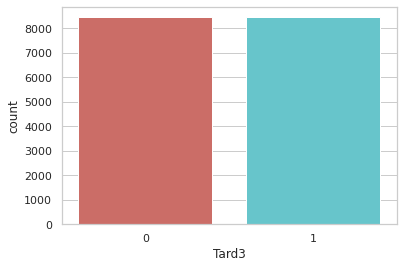

classification_report
              precision    recall  f1-score   support

           0       1.00      0.57      0.73      1490
           1       0.16      1.00      0.27       117

    accuracy                           0.60      1607
   macro avg       0.58      0.79      0.50      1607
weighted avg       0.94      0.60      0.69      1607

confusion_matrix
Accuracy: 0.60
Error rate: 0.40
Precision: 0.16
Recall: 1.00
f1_score: 0.27


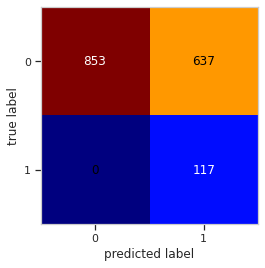

In [104]:
#@title 04 StandardScale, RL, oversample

exog_names = ['E_Despegue3', 'E_Duracion_Vuelo3',]

mapper = DataFrameMapper([(exog_names, StandardScaler())])
scaled_features = mapper.fit_transform(df2.copy(), 4)
datos_x= pd.DataFrame(scaled_features, index=df2.index, columns=exog_names)

datos_y = df2.loc[:,['Tard3']]

X_train, X_test, y_train, y_test = train_test_split(
                                        datos_x,
                                       datos_y,
                                        train_size   = 0.85,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)


model = sm.Logit(y_over, X_over)
model.exog_names[:] = exog_names 
endog_name = model.endog_names


model_fit = model.fit()

print(model_fit.summary())

# Predict..
y_pred = model_fit.predict(X_test)
prediction = list(map(round, y_pred))
prediction

print(Counter(y_over))

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='Tard3',data=y_over, palette='hls')
plt.show()

print('classification_report')
print(classification_report(y_test, prediction))
print('confusion_matrix')

cf_matrix=plot_confusion_matrix(confusion_matrix(y_test, prediction), cmap='jet')

precision=round(accuracy_score(y_test, prediction),2)
accuracy.append(['2_Variables_balanceado_StandardScale', precision])

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
print('Error rate: {:.2f}'.format(1 - accuracy_score(y_test, prediction)))
print('Precision: {:.2f}'.format(precision_score(y_test, prediction)))
print('Recall: {:.2f}'.format(recall_score(y_test, prediction)))
print('f1_score: {:.2f}'.format(f1_score(y_test, prediction)))


E_Despegue3          1.130385
E_Duracion_Vuelo3    0.956275
dtype: float64


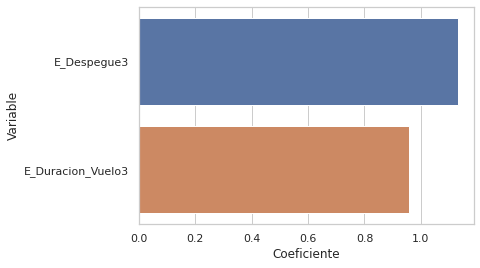

In [105]:
#@title 04 Identificar parametres importants.
print(model_fit.params)
parametros = pd.DataFrame(model_fit.params)

parametros.columns=['Coeficiente']
parametros = parametros.rename_axis('Variable').reset_index()
parametros
sns.barplot(y='Variable', x="Coeficiente", data=parametros)

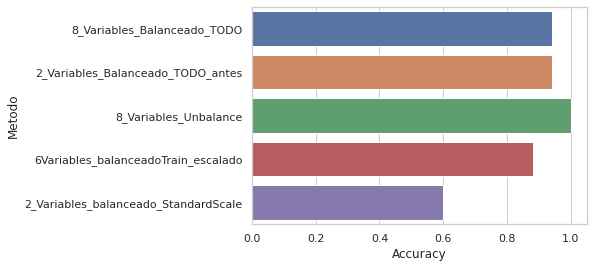

In [106]:
#@title Comparativa Accuracy
#accuracy
accuracy=pd.DataFrame(accuracy)
accuracy.columns=['Metodo', 'Accuracy']
ax= sns.barplot(y='Metodo', x="Accuracy", data=accuracy)


**Conclusió:**

Per fer correctament una regressió logística este que fer:

1.- Veure si les dades estan balancejades. Si no lo estan, es tindrà que balancejar. 

2.- Les dades es separen en train i test.

3.- Les dades de train es balanceja’n i estandaritzen.

4.- Es crea el model de regressió logística(rl).

5.- Es demana el summary de la rl:

6.- Identifiquem els paràmetres importants dintre del summary mirant els p-vàlues. Tenim que agafar el valors més petits de 0.05. I seran el valor “estadísticament” importants.

7.- Ara mirarem quins valors són “pràcticament” importants i això ens fixarem en el valors dels coeficients.

8.- tornarem a corra el model però només amb els factors identificats com important en el pas 5, 6,7.

9.- Tindrem el valor Accuracy que explica el model definitiu.


La **Accuracy** més baixa la tindrem quan només tenim 2 variables, hem estandarditzat els valors, i hem “balancejat” les dades després del "split"